# 순환 신경망 기반 감성 분석 (영화 리뷰)

## 1. 데이터 준비
* 전처리된 한글 영화평 데이터 사용 (./data/Korean_movie_reviews_2016.csv)

In [5]:
import pandas as pd 
review_df=pd.read_csv('../data/korean_movie_reviews_2016.csv')
review_df.head()

,review,label
0,부산 행 때문 너무 기대하고 봤,0
1,한국 좀비 영화 어색하지 않게 만들어졌 놀랍,1
2,조금 전 보고 왔 지루하다 언제 끝나 이 생각 드,0
3,평 밥 끼 먹자 돈 니 내고 미친 놈 정신사 좀 알 싶어 그래 밥 먹다 먹던 숟가락...,1
4,점수 대가 과 이 엑소 팬 어중간 점수 줄리 없겠 클레멘타인 이후 최고 평점 조작 ...,0


### 1-1. 입력-출력, 학습-테스트 데이터 분리

In [7]:
# 입력 데이터와 정답 데이터 추출
input_list= list(review_df.review)
label_list=list(review_df.label)
len(input_list), len(label_list)

(165384, 165384)

In [11]:
# 입력 데이터를 문장별로 토큰 단위로 분리
tokenized_input_list =[review.strip().split() for review in input_list]
len(tokenized_input_list)

165384

In [23]:
# 범주별 데이터 수 차이 확인을 위해 label grouppy 집계
review_df.groupby('label').size().reset_index(name='count')


,label,count
0,0,78578
1,1,86806


<Axes: xlabel='label'>

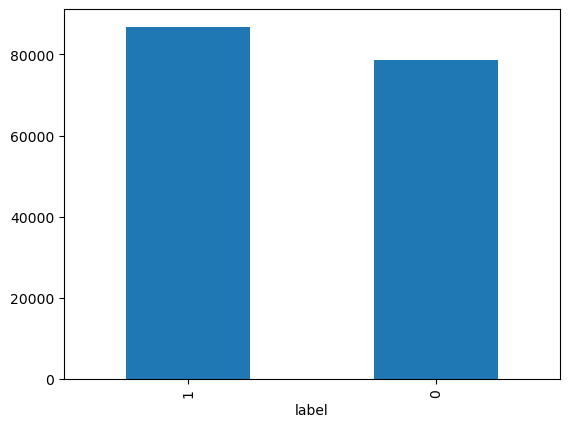

In [25]:
# 범주별 데이터 수로 막대그래프 그려보기
review_df.label.value_counts().plot(kind='bar')
#hist는 누적이다. 
#스트리트파이 레이블의 비율을 봐야됨 현실에 편항이되어있으면 봐도 됨 

In [15]:
# 학습 데이터와 평가 데이터 분리
#정답을 반영해야된다. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(tokenized_input_list, label_list, test_size=0.1)
len(X_train),len(y_train),len(X_test), len(y_test)

(148845, 148845, 16539, 16539)

### 1-2. 입력 데이터 Integer Encoding
* num_words = 사용한 단어 수 + 1 (0은 OOV에 할당)

#### [참고] 벡터에 사용할 단어수 구하기 (vocab_size)

In [ ]:
# 단어 수 제한없이 tokenizer 생성해보기


In [ ]:
# 등장 빈도수가 threshold 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 3
total_cnt = len(test_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받아서, value가 threshold보다 작은 경우
# rare_cnt와 rare_freq를 update


#### 1-2-1. 단어 집합 및 index 생성

In [33]:
# Integer Encoding을 위한 tokenizer 학습
from tensorflow.keras.preprocessing.text import Tokenizer
vocab_size=25000
max_features=vocab_size+1
tokenizer =Tokenizer(num_words=max_features)
# fit_on_texts()안에 코퍼스를 입력으로 하면 빈도수를 기준으로 단어 집합을 생성.
tokenizer.fit_on_texts(X_train)
len(tokenizer.word_index)
#integerdptj  25000개만 사용 

49592

#### 1-2-2. Integer Encoding

In [41]:
# 학습 데이터 Integer Encoding
train_sequences=tokenizer.texts_to_sequences(X_train)
len(train_sequences)
print(train_sequences[:5])

[[2459, 21, 1, 145, 272, 182, 493, 3010, 54, 87], [75, 1, 489, 6, 2363, 1, 1137, 901, 50, 4076, 95, 248, 275, 1, 489, 1521, 24], [230, 1145, 313, 1], [52, 5786, 1381, 2, 65, 390, 52, 1, 1931, 19, 901, 387, 2610, 61, 227, 1593, 656, 92, 10481, 694, 254, 412], [52, 1, 1387, 7838, 85, 85, 2560]]


In [43]:
# 테스트 데이터 Integer Encoding
test_sequences=tokenizer.texts_to_sequences(X_test)
print(test_sequences[:5])
#할당이 된다 리스트는 있는데 아무것도 없는것은 결측치 

[[6, 3012, 15, 1547, 969, 1350, 9279, 2674, 1873, 29, 472, 658, 2882, 14606, 544, 4144, 6869, 306, 344, 255, 993, 29, 987, 6783, 3622, 36, 1643, 134, 3607, 8, 6, 2005], [2151, 214, 2105, 20, 1166, 775, 198, 66, 106, 20, 417, 12324, 96, 1890, 185, 5815, 496], [39, 439, 978, 1860, 182], [30, 24, 14, 123, 104, 17026], [349, 1105]]


#### 1-2-3. Integer Encoding이 길이가 0인 review 삭제

In [47]:
# 각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스를 받아오기
drop_train=[index for index, sequence in enumerate(train_sequences) if len(sequence)==0]
#결측지가 0임 길이가 0이면 
drop_test=[index for index, sequence in enumerate(test_sequences) if len(sequence)==0]
len(drop_train),len(drop_test)

(128, 11)

In [ ]:
# 학습 데이터에서 삭제
#인덱스만 모아서 list로 모와야됨 동적배열이라 
#메모리 할당받아야됨 


In [ ]:
# 테스트 데이터에서 삭제


### 1-3. Padding

#### 1-3-1. 입력 벡터의 길이 정하기 (대부분의 문장이 잘리지 않는 크기)  

In [ ]:
# max_len 정하기 : 단어 길이의 histogram을 대부분을 포함하는 단어 길이 확인


In [ ]:
# 통계 정보 확인


In [ ]:
# 길이가 max_len 이하인 데이터의 비율 구하기


#### 1-3-2. 선택한 길이로 padding

In [ ]:
# max_len 설정

# 학습 데이터 padding

# 테스트 데이터 padding


### 1-4. 정답 데이터 One-hot Encoding

## 2. 모델 구축 (정의)

## 3. 모델 컴파일

## 4. 모델 학습

In [ ]:
# EarlyStopping, ModelCheckpoint callback 함수 설정


In [ ]:
# 모델 학습


## 5. 모델 평가

In [ ]:
# 저장된 모델 로딩하여, 테스트 데이터로 평가


In [ ]:
# predict로 테스트 데이터의 예측값 구기기


In [ ]:
# sklearn의 classification_report()로 평가 결과 확인


## 입력 문장 긍부정 판단

In [ ]:
# 입력된 문장의 긍부정 판단
review = "영화가 재미있다."


In [ ]:
# 긍부정 판단 함수


In [ ]:
# 함수 테스트
reviews = [
    '이 영화 개꿀잼 ㅋㅋㅋ',
    '하품만 나온다',
    '이 영화 핵노잼 ㅠㅠ',
    '이딴게 영화냐 ㅉㅉ',
    '와 개쩐다',
    '감독 뭐하는 놈이냐',
    '정말 세계관 최강자들의 영화다'
]



In [ ]:
# 입력 받은 문장의 긍부정 판단